Data are imported with their URL path and the PANDA library has been used to make the array of data as a data structure.

In [ ]:


import pandas as pd
import numpy as np
from scipy.io import arff                                
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import urllib.request
import io

# hepatitis data load and convert to array
data_hepatitis = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data" , header=None)
data_hepatitis = data_hepatitis.to_numpy()

# diabeties load data and convert to array
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff'
ddd=urllib.request.urlopen(url)
data, meta = arff.loadarff(io.StringIO(ddd.read().decode('utf-8')))
data_diabetes = pd.DataFrame(data)
data_diabetes = data_diabetes.to_numpy()

Class of cleaning has six methodologies to provide neat and trainable data for learning.
This class can detect incomplete data and remove rows or columns which has the most missed data and then estimate the remaining missed data based on a KNN method and then find the best features with the highest coloration with target and least correlation together.

In [ ]:
class cleaning:

    def __init__(self,data):
        self.data=data
        return
    
    def type_data_miss (self,tp=1):
        self.tp=tp
        if tp==1:
            self.missing=np.equal(self.data,"?")
            
        elif tp==2:
            self.missing=np.equal(self.data[:,0],0)
            self.missing=np.transpose([np.transpose(self.missing)]*20)
        return self
    
    
    def column_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[1]):
            num_non=sum(self.missing[:,i])
            if num_non>trsh*self.data.shape[0]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 1)
        self.missing=np.delete(self.missing, miss, 1)
        return self
    
    
    def row_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non>trsh*self.data.shape[1]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 0)
        self.missing=np.delete(self.missing, miss, 0)
        return self

    def data_derivation(self):
        perfect_data_rindex=[]
        incomplete_realdata_index=[]
        incomplete_predictdata_index=[]
        
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non==0:
                perfect_data_rindex.append(i)
            else:
                incomplete_realdata_index.append([])
                incomplete_predictdata_index.append([])
                for j in range(self.data.shape[1]):
                    if self.missing[i,j]:
                        incomplete_predictdata_index[len(incomplete_realdata_index)-1].append([i,j])
                    else:
                        incomplete_realdata_index[len(incomplete_realdata_index)-1].append([i,j])

        for i in range(len(incomplete_realdata_index)):
            dist_predict=[]
            for j in perfect_data_rindex:
                dist=0
                for k in range(len(incomplete_realdata_index[i])):
                    dist=dist+(float(self.data[j,incomplete_realdata_index[i][k][1]])-float(self.data[incomplete_realdata_index[i][k][0],incomplete_realdata_index[i][k][1]]))**2
                dist_predict.append(dist)
            m_list=min(dist_predict)
            ind=dist_predict.index(m_list)
            
            for l in range(len(incomplete_predictdata_index[i])):
                self.data[incomplete_predictdata_index[i][l][0],incomplete_predictdata_index[i][l][1]]=self.data[perfect_data_rindex[ind],incomplete_predictdata_index[i][l][1]]
        return self

    
    def best_correlation(self,num_f):
        variance=np.var(self.data.astype(float) , axis=0)
        columns=np.arange(self.data.shape[1])
        for i in range(0,len(variance)):
            if variance[i]==0:
                self.data=np.delete(self.data, columns[i], 1)
        data_df=pd.DataFrame(self.data).astype(float)
        data_correlation=data_df.corr(method='pearson').abs()
        if self.tp==1:
            clm=0
        else:
            clm=data_df.shape[1]-1
        target_correlation=data_correlation[clm]
        target_correlation=target_correlation.sort_values(ascending=False)
        data_indices=target_correlation.index
        cleaning_indices=[]
        cleaning_indices.append([data_indices[1],target_correlation[data_indices[1]]])
        
        for f in range(1,num_f):
            corr=0
            for i in range(len(cleaning_indices)+1,len(target_correlation)):
                c_test=1
                aa=target_correlation[data_indices[i]]
                for j in range(len(cleaning_indices)):
                    dc=data_correlation[data_indices[i]][cleaning_indices[j][0]]
                    c_test=c_test*(1-dc)
                c_test=c_test*aa
                if c_test>corr:
                    corr=c_test
                    ind=data_indices[i]
            cleaning_indices.append([ind,corr])
        df=pd.DataFrame(cleaning_indices)
        df=df.sort_values(by=[1])
        self.data=np.delete(self.data, df[0][0:data_indices.size-num_f], 1)
        return self
    
    def give_data(self):
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                self.data[i][j]=float(self.data[i][j])
        return self.data


For training in KNN, we need normalizing data to make all features equally important. Because in cleaning class, best trainable features have been chosen and relatively are equally important.

In [ ]:
def normalization( x_t):
    for i in range(x_t.shape[1]):
        max_f=max(x_t[:,i])
        x_t[:,i]=x_t[:,i]/max_f
    return x_t
       

Class of KNN has four methodologies to consider training data as reference for comparison to predict test data and perform cross-validation (L = number of cross-validation) on training data and finally can report accuracy, precision, recall, selectivity, and negative-predictive-value. 

In [ ]:
euclidean = lambda x1, x2: np.sqrt(np.float32(np.sum((x1 - x2)**2,axis = -1)))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
minkovski = lambda x1, x2, p=1/2: (np.sum(np.abs(x1 - x2)**p, axis=-1))**(1/p)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn 
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y)+1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
                
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]  
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) 
        y_prob /= self.K                                                          
        return y_prob, knns
    
    def evaluate_acc(self, x, y, x_test, y_test):
        y_fit = self.fit(x, y)
        y_prob, knns =y_fit.predict(x_test)
        y_pred = np.argmax(y_prob,axis=-1)
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        TP1=np.where(y_test==1 )
        TP2=np.where(y_pred == y_test)
        TP=np.intersect1d(TP1,TP2)
        FN1=np.where(y_test==1 )
        FN2=np.where(y_pred==0 )
        FN=np.intersect1d(FN1,FN2)
        FP1=np.where(y_test==0 )
        FP2=np.where(y_pred==1 )
        FP=np.intersect1d(FP1,FP2)
        TN1=np.where(y_test==0 )
        TN2=np.where(y_pred==0 )
        TN=np.intersect1d(TN1,TN2)
        recall = TP.shape[0]/(FN.shape[0]+TP.shape[0]+0.001)
        precision=TP.shape[0]/(FP.shape[0]+TP.shape[0]+0.001)
        Selectivity=TN.shape[0]/(TN.shape[0]+FP.shape[0]+0.001)
        N_predictive_v=TN.shape[0]/(TN.shape[0]+FN.shape[0]+0.001)
        return accuracy,recall,precision,Selectivity,N_predictive_v
    
def cross_v(self, x_train, y_train, L=5, k_rng=0):
    ind=int(x_train.shape[0]/L)
    acc=np.zeros((max(k_rng)-min(k_rng)+1,2))
    facc=np.zeros((max(k_rng)-min(k_rng)+1,L))
    for i in range(L):
        val_range=list(range(ind*i,ind*(i+1)))
        x_validation, y_validation = x_train[ind*i:ind*(i+1),:] , y_train[ind*i:ind*(i+1)]
        x_train_cv=np.delete(x_train, val_range, 0)
        y_train_cv=np.delete(y_train, val_range, 0)
        j=0
        for k in k_rng:
            acc[j][0]=k
            model_cv = KNN(K=k)
            acc_cv, _ ,_,_,_ = model_cv.evaluate_acc(x_train_cv, y_train_cv, x_validation, y_validation)
            facc[j][i]=acc_cv
            acc[j][1]+=acc_cv/L
            j+=1
    i=np.where(acc==max(acc[:,1]))
    best_k=int(acc[i[0][0]][0])
    return best_k
KNN.cross_v=cross_v  


Creating training data and test data for both data sets

In [ ]:
num_features_hpt=10                                                             # specifies number of features we want to have after cleaning data
hepatitis=cleaning(data_hepatitis)
data_hpt=hepatitis.type_data_miss(tp=1).column_clean(trsh=0.1).row_clean(trsh=0.1).data_derivation().best_correlation(num_f=num_features_hpt).give_data()

y_hpt, x_hpt = data_hpt[:,0].astype(int), data_hpt[:,1:num_features_hpt]
y_hpt=y_hpt-1
(N_hpt,D_hpt), C_hpt = x_hpt.shape, np.max(y_hpt)+1
np.random.seed(1334)
inds_hpt = np.random.permutation(N_hpt)
x_hpt=normalization(x_hpt)
x_train_hpt, y_train_hpt = x_hpt[inds_hpt[:100]], y_hpt[inds_hpt[:100]]
x_test_hpt, y_test_hpt = x_hpt[inds_hpt[100:]], y_hpt[inds_hpt[100:]]
# print(f'hepatitis instances (N) \t {N_hpt} \n hepatitis features (D) \t {D_hpt} \n hepatitis classes (C) \t {C_hpt}')

# cleaning diabet data
num_features_dbt=10                                                             # specifies number of features we want to have after cleaning data
diabet=cleaning(data_diabetes)
data_dbt=diabet.type_data_miss(tp=2).row_clean(trsh=0.1).best_correlation(num_f=num_features_dbt).give_data()

# creating test and train set for diabetes
y_dbt, x_dbt = data_dbt[:,num_features_dbt-1].astype(int), data_dbt[:,0:num_features_dbt-1]
(N_dbt,D_dbt), C_dbt = x_dbt.shape, np.max(y_dbt)+1 
np.random.seed(1334)
inds_dbt = np.random.permutation(N_dbt)                                                     
x_dbt=normalization(x_dbt)

x_train_dbt, y_train_dbt = x_dbt[inds_dbt[:770]], y_dbt[inds_dbt[:770]]
x_test_dbt, y_test_dbt = x_dbt[inds_dbt[770:]], y_dbt[inds_dbt[770:]]
# print(f'diabetes instances (N) \t {N_dbt} \n diabetes features (D) \t {D_dbt} \n diabetes classes (C) \t {C_dbt}')

Investigation of accuracy, recall precision, selectivity, and Negative predictive value for hepatitis with different distance functions.

In [ ]:
model_hpt = KNN(dist_fn= euclidean)
k_hpt=model_hpt.cross_v(x_train_hpt, y_train_hpt, k_rng=range(3,15))
acc_hpt,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt=KNN(K=k_hpt).evaluate_acc(x_train_hpt, y_train_hpt, x_test_hpt, y_test_hpt)
y_prob_hpt, knns_hpt = KNN(K=k_hpt).fit(x_train_hpt, y_train_hpt).predict(x_test_hpt)
print(f'KNN accuracy for hepatitis is {acc_hpt*100:.1f} with euclidean distance function.')
print(f'KNN recall for hepatitis is {recall_hpt*100:.1f} with euclidean distance function.')
print(f'KNN precision for hepatitis is {precision_hpt*100:.1f} with euclidean distance function.')
print(f'KNN Selectivity for hepatitis is {Selectivity_hpt*100:.1f} with euclidean distance function.')
print(f'KNN Negative predictive value for hepatitis is {N_predictive_v_hpt*100:.1f} with euclidean distance function.')

model_hpt = KNN(dist_fn= manhattan)
k_hpt=model_hpt.cross_v(x_train_hpt, y_train_hpt, k_rng=range(3,15))
acc_hpt,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt=KNN(K=k_hpt).evaluate_acc(x_train_hpt, y_train_hpt, x_test_hpt, y_test_hpt)
print(f'KNN accuracy for hepatitis is {acc_hpt*100:.1f} with manhattan distance function.')
print(f'KNN recall for hepatitis is {recall_hpt*100:.1f} with manhattan distance function.')
print(f'KNN precision for hepatitis is {precision_hpt*100:.1f} with manhattan distance function.')
print(f'KNN Selectivity for hepatitis is {Selectivity_hpt*100:.1f} with manhattan distance function.')
print(f'KNN Negative predictive value for hepatitis is {N_predictive_v_hpt*100:.1f} with manhattan distance function.')

model_hpt = KNN(dist_fn= minkovski)
k_hpt=model_hpt.cross_v(x_train_hpt, y_train_hpt, k_rng=range(3,15))
acc_hpt,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt=KNN(K=k_hpt).evaluate_acc(x_train_hpt, y_train_hpt, x_test_hpt, y_test_hpt)
print(f'KNN accuracy for hepatitis is {acc_hpt*100:.1f} with minkovski distance function.')
print(f'KNN recall for hepatitis is {recall_hpt*100:.1f} with minkovski distance function.')
print(f'KNN precision for hepatitis is {precision_hpt*100:.1f} with minkovski distance function.')
print(f'KNN Selectivity for hepatitis is {Selectivity_hpt*100:.1f} with minkovski distance function.')
print(f'KNN Negative predictive value for hepatitis is {N_predictive_v_hpt*100:.1f}. with minkovski distance function')


KNN accuracy for hepatitis is 90.7 with euclidean distance function.
KNN recall for hepatitis is 100.0 with euclidean distance function.
KNN precision for hepatitis is 90.5 with euclidean distance function.
KNN Selectivity for hepatitis is 20.0 with euclidean distance function.
KNN Negative predictive value for hepatitis is 99.9 with euclidean distance function.
KNN accuracy for hepatitis is 90.7 with manhattan distance function.
KNN recall for hepatitis is 100.0 with manhattan distance function.
KNN precision for hepatitis is 90.5 with manhattan distance function.
KNN Selectivity for hepatitis is 20.0 with manhattan distance function.
KNN Negative predictive value for hepatitis is 99.9 with manhattan distance function.
KNN accuracy for hepatitis is 90.7 with minkovski distance function.
KNN recall for hepatitis is 100.0 with minkovski distance function.
KNN precision for hepatitis is 90.5 with minkovski distance function.
KNN Selectivity for hepatitis is 20.0 with minkovski distance f

Investigation of accuracy, recall precision, selectivity, and Negative predictive value for diabetes with different distance functions.

In [ ]:
model_dbt = KNN(euclidean)
k_dbt=model_dbt.cross_v(x_train_dbt, y_train_dbt, k_rng=range(3,15))
acc_dbt,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt=KNN(K=k_dbt).evaluate_acc(x_train_dbt, y_train_dbt, x_test_dbt, y_test_dbt,)
y_prob_dbt, knns_dbt = KNN(K=k_dbt).fit(x_train_dbt, y_train_dbt).predict(x_test_dbt)
print(f'KNN accuracy for diabetes is {acc_dbt*100:.1f} with euclidean distance function.')
print(f'KNN recall for diabetes is {recall_dbt*100:.1f} with euclidean distance function.')
print(f'KNN precision for diabetes is {precision_dbt*100:.1f} with euclidean distance function.')
print(f'KNN Selectivity for diabetes is {Selectivity_dbt*100:.1f} with euclidean distance function.')
print(f'KNN Negative predictive value for diabetes is {N_predictive_v_dbt*100:.1f} with euclidean distance function.')

model_dbt = KNN(manhattan)
k_dbt=model_dbt.cross_v(x_train_dbt, y_train_dbt, k_rng=range(3,15))
acc_dbt,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt=KNN(K=k_dbt).evaluate_acc(x_train_dbt, y_train_dbt, x_test_dbt, y_test_dbt,)
print(f'KNN accuracy for diabetes is {acc_dbt*100:.1f} with manhattan distance function.')
print(f'KNN recall for diabetes is {recall_dbt*100:.1f} with manhattan distance function.')
print(f'KNN precision for diabetes is {precision_dbt*100:.1f} with manhattan distance function.')
print(f'KNN Selectivity for diabetes is {Selectivity_dbt*100:.1f} with manhattan distance function.')
print(f'KNN Negative predictive value for diabetes is {N_predictive_v_dbt*100:.1f} with euclidean distance function.')

model_dbt = KNN(minkovski)
k_dbt=model_dbt.cross_v(x_train_dbt, y_train_dbt, k_rng=range(3,15))
acc_dbt,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt=KNN(K=k_dbt).evaluate_acc(x_train_dbt, y_train_dbt, x_test_dbt, y_test_dbt,)
print(f'KNN accuracy for diabetes is {acc_dbt*100:.1f} with minkovski distance function.')
print(f'KNN recall for diabetes is {recall_dbt*100:.1f} with minkovski distance function.')
print(f'KNN precision for diabetes is {precision_dbt*100:.1f} with minkovski distance function.')
print(f'KNN Selectivity for diabetes is {Selectivity_dbt*100:.1f} with minkovski distance function.')
print(f'KNN Negative predictive value for diabetes is {N_predictive_v_dbt*100:.1f} with minkovski distance function.')

KNN accuracy for diabetes is 62.9 with euclidean distance function.
KNN recall for diabetes is 60.0 with euclidean distance function.
KNN precision for diabetes is 65.4 with euclidean distance function.
KNN Selectivity for diabetes is 65.9 with euclidean distance function.
KNN Negative predictive value for diabetes is 60.6 with euclidean distance function.
KNN accuracy for diabetes is 62.9 with manhattan distance function.
KNN recall for diabetes is 60.0 with manhattan distance function.
KNN precision for diabetes is 65.4 with manhattan distance function.
KNN Selectivity for diabetes is 65.9 with manhattan distance function.
KNN Negative predictive value for diabetes is 60.6 with euclidean distance function.
KNN accuracy for diabetes is 62.9 with minkovski distance function.
KNN recall for diabetes is 60.0 with minkovski distance function.
KNN precision for diabetes is 65.4 with minkovski distance function.
KNN Selectivity for diabetes is 65.9 with minkovski distance function.
KNN Nega

Demonstration of classification with best K hyperparameter (hepatitis).

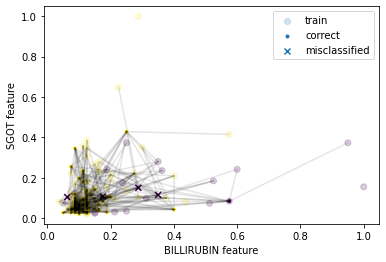

In [ ]:
y_pred_hpt = np.argmax(y_prob_hpt,axis=-1)

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test_hpt == y_pred_hpt
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train_hpt[:,6], x_train_hpt[:,7], c= y_train_hpt, marker='o', alpha=.2, label='train')
plt.scatter(x_test_hpt[correct,6], x_test_hpt[correct,7], marker='.', c=y_pred_hpt[correct], label='correct')
plt.scatter(x_test_hpt[incorrect,6], x_test_hpt[incorrect,7], marker='x', c=y_test_hpt[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test_hpt.shape[0]):
    for k in range(k_hpt):
        hor = x_test_hpt[i,6], x_train_hpt[knns_hpt[i,k],6]
        ver = x_test_hpt[i,7], x_train_hpt[knns_hpt[i,k],7]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.xlabel('BILLIRUBIN feature')
plt.ylabel('SGOT feature')
plt.legend()
plt.show()

Demonstration of classification with best K hyperparameter (diabetes)

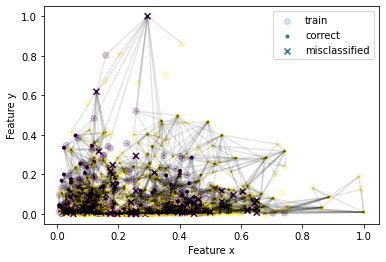

In [ ]:
y_pred = np.argmax(y_prob_dbt,axis=-1)

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test_dbt == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train_dbt[:,1], x_train_dbt[:,6], c= y_train_dbt, marker='o', alpha=.2, label='train')
plt.scatter(x_test_dbt[correct,1], x_test_dbt[correct,6], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test_dbt[incorrect,1], x_test_dbt[incorrect,6], marker='x', c=y_test_dbt[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test_dbt.shape[0]):
    for k in range(k_dbt):
        hor = x_test_dbt[i,1], x_train_dbt[knns_dbt[i,k],1]
        ver = x_test_dbt[i,6], x_train_dbt[knns_dbt[i,k],6]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.xlabel('Feature x')
plt.ylabel('Feature y')
plt.legend()
plt.show()

Decision Boundary for two features with highest correlations with different K values (hepatitis).

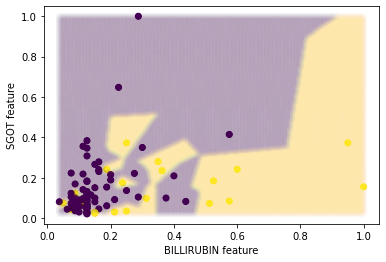

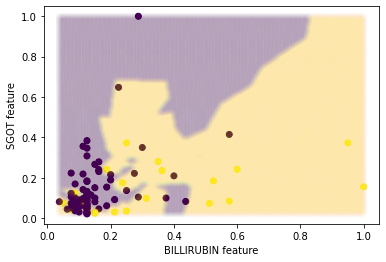

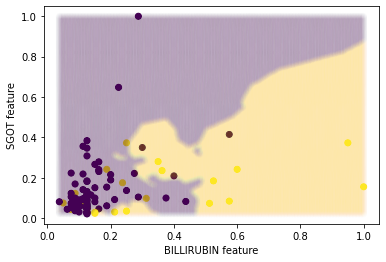

In [ ]:
#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x_hpt[:,6]), np.max(x_hpt[:,6]), 200)
x1v = np.linspace(np.min(x_hpt[:,7]), np.max(x_hpt[:,7]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all_hpt = np.vstack((x0.ravel(),x1.ravel())).T

for k in range(1,4):
  model = KNN(K=k)

  y_train_prob_hpt = np.zeros((y_train_hpt.shape[0], 2))
  y_train_prob_hpt[np.arange(y_train_hpt.shape[0]), y_train_hpt] = 1

  #to get class probability of all the points in the 2D grid
  y_prob_all_hpt, _ = model.fit(x_train_hpt[:,[6,7]], y_train_hpt).predict(x_all_hpt)

  y_pred_all_hpt = np.zeros_like(y_prob_all_hpt)
  y_pred_all_hpt[np.arange(x_all_hpt.shape[0]), np.argmax(y_prob_all_hpt, axis=-1)] = 1
  # print(x_train_hpt.shape)
  # print(y_train_prob.shape)
  plt.scatter(x_train_hpt[:,6], x_train_hpt[:,7], c=y_train_prob_hpt[:,0], marker='o', alpha=1)
  plt.scatter(x_all_hpt[:,0], x_all_hpt[:,1], c=y_pred_all_hpt[:,0], marker='o', alpha=0.01)
  plt.xlabel('BILLIRUBIN feature')
  plt.ylabel('SGOT feature')
  plt.show()

Decision Boundary for two features with highest correlations with diffrent K value (diabetes).

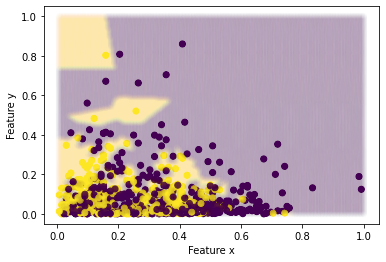

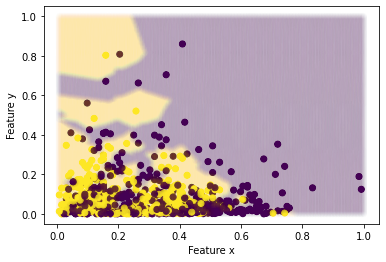

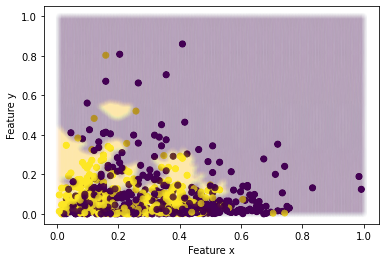

In [ ]:
#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x_dbt[:,1]), np.max(x_dbt[:,1]), 200)
x1v = np.linspace(np.min(x_dbt[:,6]), np.max(x_dbt[:,6]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all_dbt = np.vstack((x0.ravel(),x1.ravel())).T

for k in range(1,4):
  model = KNN(K=k)

  y_train_prob_dbt = np.zeros((y_train_dbt.shape[0], 2))
  y_train_prob_dbt[np.arange(y_train_dbt.shape[0]), y_train_dbt] = 1

  #to get class probability of all the points in the 2D grid
  y_prob_all_dbt, _ = model.fit(x_train_dbt[:,[1,6]], y_train_dbt).predict(x_all_dbt)

  y_pred_all_dbt = np.zeros_like(y_prob_all_dbt)
  y_pred_all_dbt[np.arange(x_all_dbt.shape[0]), np.argmax(y_prob_all_dbt, axis=-1)] = 1
  # print(x_train_hpt.shape)
  # print(y_train_prob.shape)
  plt.scatter(x_train_dbt[:,1], x_train_dbt[:,6], c=y_train_prob_dbt[:,0], marker='o', alpha=1)
  plt.scatter(x_all_dbt[:,0], x_all_dbt[:,1], c=y_pred_all_dbt[:,0], marker='o', alpha=0.01)
  plt.xlabel('Feature x')
  plt.ylabel('Feature y')
  plt.show()

Investigation of K effect on accuracy in hepatitis data

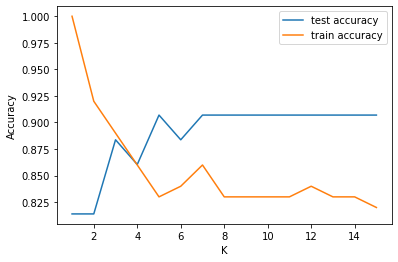

In [ ]:
plt_k_hpt_acc=np.zeros((15,2))
plt_k_hpt_acc_tr=np.zeros((15,2))
for i in range(1,16):
  model_hpt = KNN(dist_fn= minkovski)
  acc_hpt,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt=KNN(K=i).evaluate_acc(x_train_hpt, y_train_hpt, x_test_hpt, y_test_hpt)
  acc_hpt_train,recall_hpt,precision_hpt,Selectivity_hpt,N_predictive_v_hpt=KNN(K=i).evaluate_acc(x_train_hpt, y_train_hpt, x_train_hpt, y_train_hpt)
  plt_k_hpt_acc[i-1,:]=[i,acc_hpt]
  plt_k_hpt_acc_tr[i-1,:]=[i,acc_hpt_train]
plt.plot(plt_k_hpt_acc[:,0],plt_k_hpt_acc[:,1],label='test accuracy')
plt.plot(plt_k_hpt_acc_tr[:,0],plt_k_hpt_acc_tr[:,1],label='train accuracy')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()

Investigation of K effect on accuracy in diabetes data

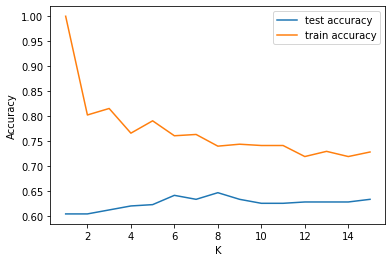

In [ ]:
plt_k_dbt_acc=np.zeros((15,2))
plt_k_dbt_acc_tr=np.zeros((15,2))
for i in range(1,16):
  model_dbt = KNN(euclidean)
  acc_dbt,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt=KNN(K=i).evaluate_acc(x_train_dbt, y_train_dbt, x_test_dbt, y_test_dbt,)
  acc_dbt_train,recall_dbt,precision_dbt,Selectivity_dbt,N_predictive_v_dbt=KNN(K=i).evaluate_acc(x_train_dbt, y_train_dbt, x_train_dbt, y_train_dbt)
  plt_k_dbt_acc[i-1,:]=[i,acc_dbt]
  plt_k_dbt_acc_tr[i-1,:]=[i,acc_dbt_train]
plt.plot(plt_k_dbt_acc[:,0],plt_k_dbt_acc[:,1],label='test accuracy')
plt.plot(plt_k_dbt_acc_tr[:,0],plt_k_dbt_acc_tr[:,1],label='train accuracy')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()